In [1]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

import sys
sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor
from conceptor.utils import plot_embed_with_label, score
from conceptor.tokenizer import CANCER_CODE

In [2]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/15672/data'
df_label = pd.read_pickle(os.path.join(data_path, 'ALL.ITRP.PATIENT.TABLE.HUGO'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ALL.ITRP.TPM.TABLE.HUGO'))
df_tpm.shape, df_label.shape

((1231, 15672), (1231, 34))

In [3]:
df = pd.read_excel('./ITRP_dataset.xlsx')
df.head()

,Cohort,Cancer Type,ICI,ICI Target,Patients(R/NR),Sequencer,Reference
0,IMVigor210,BLCA,atezolizumab,PD-L1,298(68/230),HiSeq2500,"IMvigor210 Study Group. The Lancet, 2017"
1,Rose,BLCA,"atezolizumab, avelumab, durvalumab, nivolumab,...",PD-L1 or PD1,89(16/73),NovaSeq6000,Rose et al. BJC 2021
2,Snyder,BLCA,atezolizumab,PD-L1,21(7/14),HiSeq4000,Snyder et al. PLoS Med. 2017
3,Zhao,GBM,"nivolumab, pembrolizumab",PD1,25(11/14),HiSeq2000,"Zhao et al. Nature Medicine, 2019"
4,Choueiri,KIRC,nivolumab,PD1,16(3/13),HiSeq2500,"Choueiri et al. Clinical Cancer Research, 2016"


# save cohort one-by-one

In [4]:
for i in range(len(df)):
    s = df.iloc[i]
    cohort = s['Cohort']
    cancer = s['Cancer Type']
    dfc = pd.read_excel('./ITRP_dataset.xlsx', sheet_name=cohort, index_col=0)
    dft = df_tpm.loc[dfc.index]
    dfc.to_csv('./%s/%s_clinical.tsv' % (cancer, cohort), sep = '\t')
    dft.to_csv('./%s/%s_tpm.tsv' % (cancer, cohort), sep = '\t')

## load all

In [5]:
from glob import glob

In [6]:
fs = glob('./*/*_clinical.tsv')

In [7]:
res = []
for f in fs:
    dfc = pd.read_csv(f, sep='\t', index_col=0)
    res.append(dfc)

In [8]:
df_clinical = pd.concat(res)
df_mrna = df_tpm.loc[df_clinical.index]

In [9]:
ICI_target_map = {'PD-L1': 'PDL1',
 'PD1': 'PD1',
 'CTLA4': 'CTLA4',
 'CTLA4+PD1': 'PD1+CTLA4',
 'PD1 + CTLA4': 'PD1+CTLA4',
 'CTLA4 + PD1': 'PD1+CTLA4',
 'PDL1': 'PDL1'}

ICI_map = {'Atezolizumab':'Atezo', 
           'Nivolumab':'Nivo', 
           'Pembrolizumab':'Pembro', 
           'Pembro':'Pembro', 
           'ipilimumab':'Ipi',
          'Ipilimumab + Pembrolizumab':'Ipi+Pembro',
          'Ipilimumab + Nivolumab':'Ipi+Nivo',
          'Nivolumab + Ipilimumab':'Ipi+Nivo',
           'unknow':'Uknow',
          }

tissue_map = {'bladder': 'Bladder',
 'skin': 'Skin',
 'Skin': 'Skin', 
 'SKin': 'Skin',
 'SQ': 'Skin',
 'R upper arm': 'Skin',
 'ureter': 'Ureter',
 'kidney': 'Kidney',
 'Kidney': 'Kidney',
 'lymph node': 'Lymph node',
 'LN': 'Lymph node',
 'Lymph-node': 'Lymph node',
 'Brain': 'Brain',
 'brain': 'Brain',
 'mucosa': 'Mucosa',
 'Mucosa': 'Mucosa',
 'Ocular': 'Ocular',
 'ocular/uveal': 'Ocular',
 'liver/visceral': 'Liver',
 'liver': 'Liver',
 'soft tissue': 'Soft tissue',
 'lung': 'Lung',
 'Lung': 'Lung',
 'other': 'Other',
 'Other': 'Other',
 'Penile': 'Other',
 'bone': 'Other',
 'Abdomen': 'Other',
 'Bowel': 'Other',
 'Adbdominal wall': 'Other',
 'Colon': 'Other',
 'Inguinal': 'Other',
 'Clavicle': 'Other',
 'Adrenal': 'Other',
 'acral': 'Other'}

In [10]:
df_clinical['ICI_target_map'] = df_clinical.ICI_target.map(ICI_target_map).fillna('Other')
df_clinical['ICI_map'] = df_clinical.ICI.map(ICI_map).fillna('Other')

df_clinical['Biopsy_site'] = df_clinical['Tissue'].map(tissue_map)

In [11]:
def fill_recist(row):
    if pd.isna(row['RECIST']):
        return 'PR' if row['response_label'] == 'R' else 'PD'
    else:
        return row['RECIST']

# Zhao Cohort has no RECIST labels, so we creat psedo-RECIST labels for no-FT
df_clinical['RECIST'] = df_clinical.apply(fill_recist, axis=1)

In [12]:
df_clinical['sub_cohort'] = df_clinical['cohort'] + '(' + df_clinical['ICI_map'] + ')'
size = df_clinical.groupby(['sub_cohort']).size()
sub_cohort_used_flag = df_clinical.groupby(['sub_cohort', 'response_label']).size().unstack().dropna()
sub_cohort_used_flag = sub_cohort_used_flag[sub_cohort_used_flag > 2].dropna().sort_index()
df_clinical['sub_cohort_used_flag'] = df_clinical['sub_cohort'].isin(sub_cohort_used_flag.index)

In [13]:
sub_cohort_used_flag

response_label,NR,R
sub_cohort,,
Allen(Ipi),26.0,13.0
Choueiri(Nivo),13.0,3.0
Gide(Ipi+Pembro),9.0,16.0
Gide(Nivo),5.0,4.0
Gide(Pembro),17.0,15.0
Hugo(Pembro),12.0,14.0
IMVigor210(Atezo),230.0,68.0
IMmotion150(Atezo),117.0,48.0
Kim(Pembro),33.0,12.0


In [14]:
## process TMB
df_label = df_clinical
capsize= 35.8
df_label.loc[df_label.cohort == 'Hugo', 'real_TMB'] = (2**(df_label.loc[df_label.cohort == 'Hugo', 'log2_tmb.dan'])*capsize)
df_label.loc[df_label.cohort == 'Allen', 'real_TMB'] = (2**(df_label.loc[df_label.cohort == 'Allen', 'log2_tmb.dan'])*capsize)
df_label.loc[df_label.cohort == 'MGH', 'real_TMB'] = (2**(df_label.loc[df_label.cohort == 'MGH', 'log2_tmb.dan'])*capsize)

df_label.loc[df_label.cohort == 'Liu', 'real_TMB'] = (2**(df_label.loc[df_label.cohort == 'Liu', 'log2_tmb.dan'])*capsize)
df_label.loc[df_label.cohort == 'Riaz', 'real_TMB'] = (2**(df_label.loc[df_label.cohort == 'Riaz', 'log2_tmb.dan'])*capsize)
df_label.loc[df_label.cohort == 'Rose', 'real_TMB'] = df_label.loc[df_label.cohort == 'Rose', 'TMB']
df_label.loc[df_label.cohort == 'IMVigor210', 'real_TMB'] = df_label.loc[df_label.cohort == 'IMVigor210', 'TMB (FMOne mutation burden per MB)']

In [15]:
df_label.to_pickle('./ITRP.PATIENT.TABLE')
df_mrna.to_pickle('./ITRP.TPM.TABLE')

In [16]:
df_clinical = pd.read_pickle('./ITRP.PATIENT.TABLE')
df_mrna = pd.read_pickle('./ITRP.TPM.TABLE')

In [17]:
dfs = df_clinical.groupby(['cohort', 'response_label']).size().unstack()
dfs['Total'] = dfs.sum(axis=1)
dfs.sort_values('Total')

response_label,NR,R,Total
cohort,,,
Choueiri,13,3,16
Miao,12,5,17
Snyder,14,7,21
SU2CLC2,17,8,25
Zhao,14,11,25
Hugo,12,14,26
MGH,22,12,34
Allen,26,13,39
Kim,33,12,45


Text(0, 0.5, 'Number of Patients')

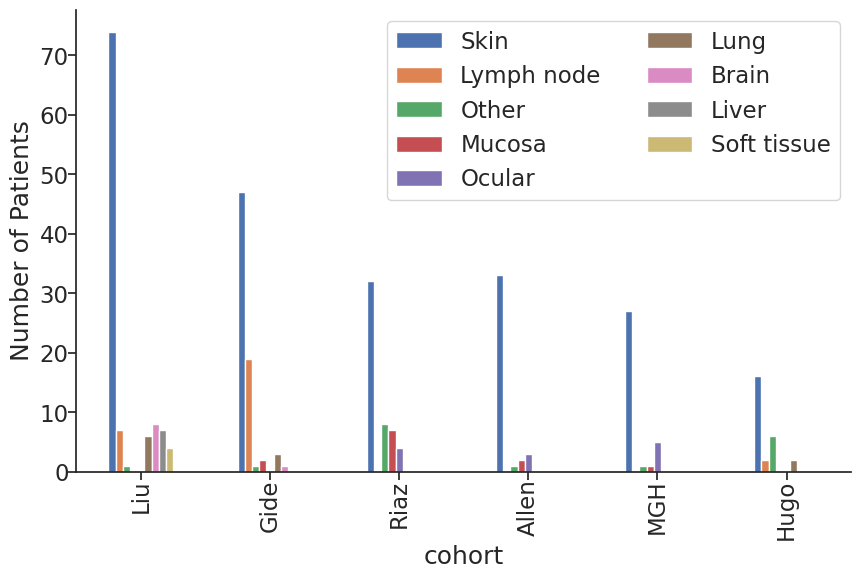

In [18]:
skcm = df_clinical[df_clinical.cancer_type == 'SKCM']
data = skcm.groupby('cohort').apply(lambda x:x.Biopsy_site.value_counts()).unstack()
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
data = data[data.sum().sort_values(ascending=False).index]
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(kind='bar', ax = ax)
ax.legend(loc='upper right', ncol=2)
ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_ylabel('Number of Patients')

Text(0, 0.5, 'Number of Patients')

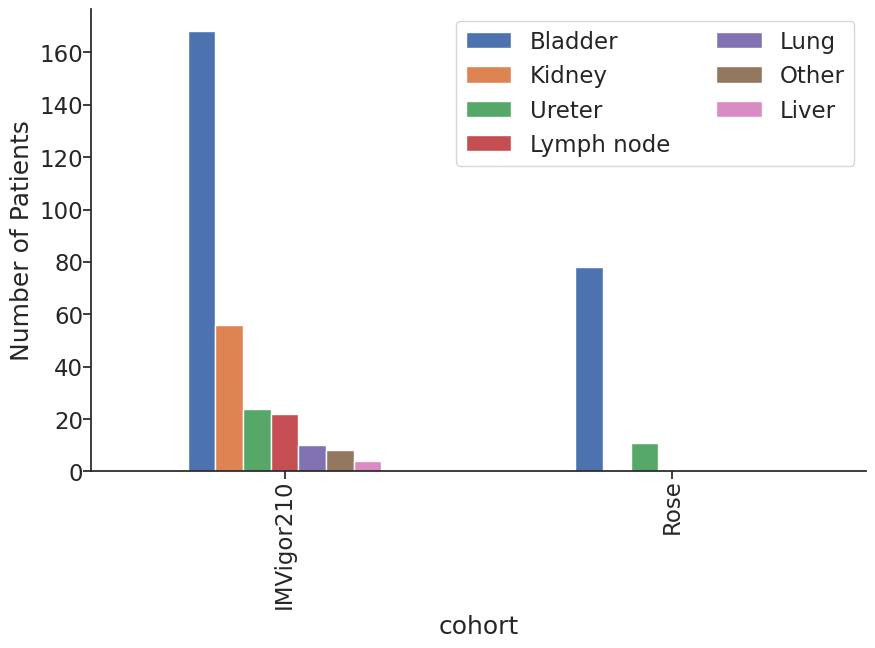

In [19]:
skcm = df_clinical[df_clinical.cancer_type == 'BLCA']
data = skcm.groupby('cohort').apply(lambda x:x.Biopsy_site.value_counts()).unstack()
data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
data = data[data.sum().sort_values(ascending=False).index]
fig, ax = plt.subplots(figsize=(10, 6))
data.plot(kind='bar', ax = ax)
ax.legend(loc='upper right', ncol=2)
ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_ylabel('Number of Patients')

In [20]:
skcm = df_clinical[df_clinical.cohort == 'IMVigor210']
data = skcm.groupby('cohort').apply(lambda x:x['Immune phenotype'].value_counts())
# data = data.loc[data.sum(axis=1).sort_values(ascending=False).index]
# data = data[data.sum().sort_values(ascending=False).index]
# fig, ax = plt.subplots(figsize=(10, 6))
# data.plot(kind='bar', ax = ax)
# ax.legend(loc='upper right', ncol=2)
# ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
# sns.despine(top=True, right=True, left=False, bottom=False)
# ax.set_ylabel('Number of Patients')

<Axes: xlabel='cohort'>

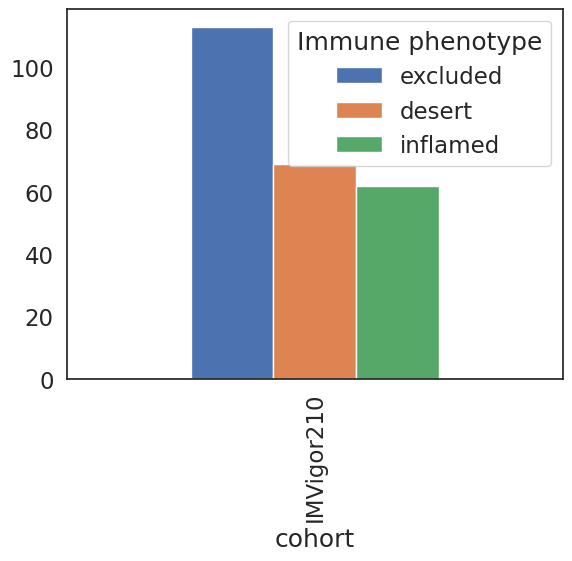

In [21]:
data.plot(kind='bar')

In [27]:
df_clinical[~df_clinical.real_TMB.isna()].cohort.unique()

array(['IMVigor210', 'Rose', 'Allen', 'Hugo', 'Liu', 'MGH', 'Riaz'],
      dtype=object)